In [138]:
import numpy as np
runtime_hard={}
runtime_soft={}
######## DO NOT MODIFY THIS FUNCTION ########
def draw_rand_label(x, label_list):
    seed = abs(np.sum(x))
    while seed < 1:
        seed = 10 * seed
    seed = int(1000000 * seed)
    np.random.seed(seed)
    return np.random.choice(label_list)
#############################################


class Q1:

    def feature_means(self, banknote):
        features=banknote[:,:4]
        return np.mean(features,axis=0)

    def covariance_matrix(self, banknote):
        features=banknote[:,:4]
        return np.cov(features.T)

    def feature_means_class_1(self, banknote):
        data_class_1 = banknote[banknote[:,4] == 1, :4]
        return np.mean(data_class_1,axis=0)

    def covariance_matrix_class_1(self, banknote):
        data_class_1 = banknote[banknote[:,4] == 1, :4]
        return np.cov(data_class_1.T)


class HardParzen:
    def __init__(self, h):
        self.h = h

    def train(self, train_inputs, train_labels):
        self.label_list = np.unique(train_labels)
        self.label_length=len(np.unique(train_labels))
        self.train_inputs=train_inputs
        self.train_labels=train_labels

    def compute_predictions(self, test_data):
        neighbours=[]
        
        length=test_data.shape[0]
        classes_pred=np.zeros(length)
        
        counts=np.ones((length,self.label_length))
        
        radius=self.h
        for i in range(0,len(test_data)):
            
            distance=(np.sum((np.abs(test_data[i] - self.train_inputs)) ** 2, axis=1)) ** (1.0 / 2)
            neighbours = np.array([j for j in range(len(distance)) if distance[j] < radius])
            for k in neighbours:
                counts[i,int(self.train_labels[k])]+=1
            if max(counts[i,:])==1:
                classes_pred[i]=draw_rand_label(test_data[i],self.label_list)
            else:
                classes_pred[i] = np.argmax(counts[i, :])
        return classes_pred


class SoftRBFParzen:
    def __init__(self, sigma):
        self.sigma  = sigma

    def train(self, train_inputs, train_labels):
        self.label_list = np.unique(train_labels)
        self.label_length=len(np.unique(train_labels))
        self.train_inputs=train_inputs
        self.train_labels=train_labels

    def compute_predictions(self, test_data):
        neighbours=[]
        
        length=test_data.shape[0]
        classes_pred=np.zeros(length)
        counts=np.ones((length,self.label_length))
        for i in range(len(test_data)):
            distances = (np.sum((np.abs(test_data[i] - self.train_inputs)) ** 2, axis=1)) ** (1.0 / 2)
            dic = dict.fromkeys(self.label_list, 1)
            for j in range(len(distances)):
                sig=(1/(np.sqrt(2*np.pi)*self.sigma))*np.exp(-(distances[j]**2/(2*self.sigma**2)))
                dic[self.train_labels[j]]+=sig
            classes_pred[i]= max(dic, key=dic.get)
        return classes_pred


def split_dataset(banknote):
    length=list(range(0,len(banknote)))
    train_index=[]
    validation_index=[]
    test_index=[]
    
    for i in range(0,len(length)):
        if i%5==0 or i%5==1 or i%5==2:
            train_index.append(i)
        elif i%5==3:
            validation_index.append(i)
        elif i%5==4:
            test_index.append(i)
    train=banknote[train_index]
    validation=banknote[validation_index]
    test=banknote[test_index]
    return (train,validation,test)


class ErrorRate:
    def __init__(self, x_train, y_train, x_val, y_val):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

    def hard_parzen(self, h):
        knn_hard=HardParzen(h)
        knn_hard.train(self.x_train,self.y_train)
        knn_hard_pred=knn_hard.compute_predictions(self.x_val)

        n_classes = len(np.unique(knn_hard_pred))
        total_correct=0
        for i in range(0,len(knn_hard_pred)):
            if knn_hard_pred[i]==self.y_val[i]:
                total_correct+=1       
        total_pred=len(knn_hard_pred)        
        
        return 1-((float(total_correct) / float(total_pred)))

    def soft_parzen(self, sigma):
        knn_soft=SoftRBFParzen(sigma)
        knn_soft.train(self.x_train,self.y_train)
        knn_soft_pred=knn_soft.compute_predictions(self.x_val)
        correct=0
        for j in range(0,len(knn_soft_pred)):
            if knn_soft_pred[j]==self.y_val[j]:
                correct+=1
        total_pred=len(knn_soft_pred) 
        return 1-((float(correct) / float(total_pred)))

def get_test_errors(banknote):
#     split_dataset(banknote)
    dataset=split_dataset(banknote)
    test=dataset[2]
    test_label=test[:,4]

    train=dataset[0]
    train_label=train[:,4]
    error=ErrorRate(train[:,:4],train_label,test[:,:4],test_label)
    h=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
    h_error={}
    h_runtime={}
    for i in range(len(h)):
        t1 = time.perf_counter()
        h_error[h[i]]= error.hard_parzen(h[i])
        t2 = time.perf_counter()
        h_runtime[h[i]]=t2-t1
    sigma=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
    s_error={}
    s_runtime={}
    for i in range(len(sigma)):
        t1 = time.perf_counter()
        s_error[sigma[i]]= error.soft_parzen(sigma[i])
        t2 = time.perf_counter()
        s_runtime[sigma[i]]=t2-t1
    soft_min=min(s_error,key=s_error.get)
    hard_min=min(h_error,key=h_error.get)
#     return np.array([h_error[hard_min],s_error[hard_min] ])
#     return h_error,s_error
    return h_runtime,s_runtime

def random_projections(X, A):
    res=X.dot(A)
    res=res/np.sqrt(2)
    return res

In [ ]:
h_res=np.array([0.1627719,0.1445142,0.146569,0.1420796,0.1549656,0.1401445,0.1566806,
  0.1782113,0.5506031,0.6390533])
s_res=np.array([2.3074178,2.2947799,2.2317911,2.1608443,2.2213071,2.2046043,2.116726,
  2.1719479,4.7158014,3.6008611])
A=np.random.normal(0,1,size=(4,2))
for i in range(0,3):
    temp=np.genfromtxt('data_banknote_authentication.txt',delimiter=',')
    X_train=temp[:,:4]
    
    random_proj=random_projections(X_train,A)
    res=np.column_stack((X_train,temp[:,4]))

    banknote_proj=np.column_stack((random_proj,temp[:,4]))

    best=get_test_errors(banknote)

    h_arr=np.array(list(best[0].values()))
    s_arr=np.array(list(best[1].values()))

    h_res=np.vstack( (h_res,h_arr))
    s_res=np.vstack( (s_res,s_arr))
    print(i)
print(h_res)
print(s_res)

0


array([[2.3074178, 2.2947799, 2.2317911, 2.1608443, 2.2213071, 2.2046043,
        2.116726 , 2.1719479, 4.7158014, 3.6008611],
       [2.3508537, 2.3602785, 2.2520102, 2.2346474, 2.3127386, 2.2779814,
        2.1336263, 2.3539616, 2.7930272, 2.8346267]])

In [114]:
np.array(best[0].values())

array(dict_values([0.21137710000039078, 0.15897300000142423, 0.22847249999904307, 0.1561122000020987, 0.13858370000161813, 0.14344079999864334, 0.15101100000174483, 0.18800809999811463, 0.5485416000010446, 0.7132577000011224]),
      dtype=object)

In [148]:
h_arrr=np.array(list(best[0].values()))
s_arrr=np.array(list(best[1].values()))

h_ress=np.vstack( (h_ress,h_arr) )
print(h_ress)

NameError: name 'h_ress' is not defined

In [ ]:
np.

In [146]:
res=np.vstack((res,arr1))
print(res)

[[0.1627719 0.1445142 0.146569  0.1420796 0.1549656 0.1401445 0.1566806
  0.1782113 0.5506031 0.6390533]
 [2.3074178 2.2947799 2.2317911 2.1608443 2.2213071 2.2046043 2.116726
  2.1719479 4.7158014 3.6008611]
 [0.1627719 0.1445142 0.146569  0.1420796 0.1549656 0.1401445 0.1566806
  0.1782113 0.5506031 0.6390533]]


In [156]:
h_res_avg=np.mean(h_res,axis=0)
print(avg)

print(res.shape)
# h ∈ {0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0}
# σ ∈ {0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0}

[0.87765387 0.86126943 0.84164303 0.81500117 0.8437461  0.82829777
 0.81002907 0.84279017 1.93900253 1.62632257]
(1372, 5)


In [158]:
print(h_res_avg)
print(h_res)

[0.16533677 0.16309955 0.157419   0.1597099  0.16706297 0.16426838
 0.1664606  0.19096587 0.51049093 0.6808881 ]
[[0.1627719 0.1445142 0.146569  0.1420796 0.1549656 0.1401445 0.1566806
  0.1782113 0.5506031 0.6390533]
 [0.1743979 0.1659155 0.1500677 0.1664755 0.1572324 0.1611295 0.1575361
  0.186208  0.4829296 0.7484054]
 [0.1546424 0.1677423 0.1664739 0.1701931 0.1967391 0.2022126 0.1979552
  0.2194027 0.5225029 0.6696326]
 [0.1695349 0.1742262 0.1665654 0.1600914 0.1593148 0.1535869 0.1536705
  0.1800415 0.4859281 0.6664611]]


In [65]:
banknote=np.genfromtxt('data_banknote_authentication.txt',delimiter=',')
best=get_test_errors(banknote)
print(best)
# dataset=split_dataset(banknote)
# test=dataset[2]
# test_label=test[:,4]

# train=dataset[0]
# train_label=train[:,4]

# er=ErrorRate(train[:,:4],train_label,test[:,:4],test_label)
# res=er.hard_parzen(1)
# print(res)

# knn_hard=SoftRBFParzen(0.4)
# knn_hard.train(train[:,:4],train_label)
# knn_hard_pred=knn_hard.compute_predictions(test[:,:4])
# print(knn_hard_pred)


({0.01: 0.1636859000000186, 0.1: 0.15863890000036918, 0.2: 0.16135420000000522, 0.3: 0.1285171999998056, 0.4: 0.1520850000001701, 0.5: 0.13916390000031242, 1.0: 0.16673110000010638, 3.0: 0.18227370000022347, 10.0: 0.5162836000004063, 20.0: 0.6741210000000137}, {0.01: 3.0228048999997554, 0.3: 2.8113422000001265, 0.4: 2.8107648000000154, 0.5: 2.5916659999998046, 1.0: 2.400005399999827, 3.0: 2.3165053999996417, 10.0: 2.2776159999998526, 20.0: 2.310085400000389})


Text(0.5, 1.0, 'Error Analysis')

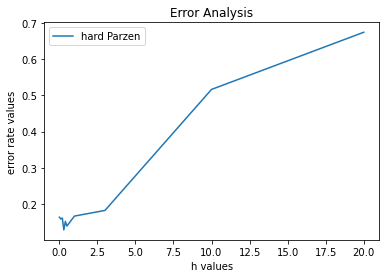

In [68]:
#Error Analysis- Q5
import matplotlib.pyplot as plt
plt.plot(list(best[0].keys()) , list(best[0].values()) , label='hard Parzen')
plt.plot(list(best[1].keys()) , list(best[1].values()),label='Soft Parzen')
plt.legend();
plt.xlabel('h/sigma values')
plt.ylabel('error rate values')
plt.title('Error Analysis')

Text(0.5, 1.0, 'Hard Parzen-run time analysis')

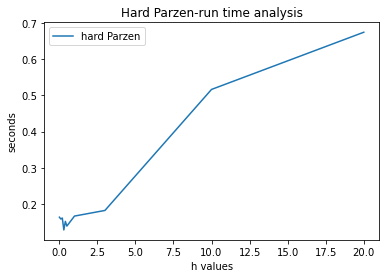

In [73]:
#Q7 a
plt.plot(list(best[0].keys()) , list(best[0].values()) , label='hard Parzen')
plt.legend();
plt.xlabel('h values')
plt.ylabel('seconds')
plt.title('Hard Parzen-run time analysis')

Text(0.5, 1.0, 'Soft Parzen-run time analysis')

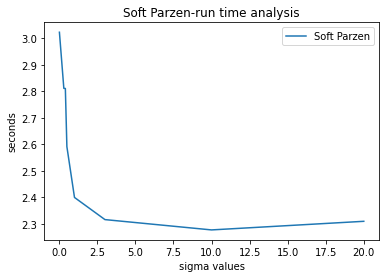

In [74]:
#Q7 b
plt.plot(list(best[1].keys()) , list(best[1].values()),label='Soft Parzen')
plt.legend();
plt.xlabel('sigma values')
plt.ylabel('seconds')
plt.title('Soft Parzen-run time analysis')

In [75]:
best

({0.01: 0.1636859000000186,
  0.1: 0.15863890000036918,
  0.2: 0.16135420000000522,
  0.3: 0.1285171999998056,
  0.4: 0.1520850000001701,
  0.5: 0.13916390000031242,
  1.0: 0.16673110000010638,
  3.0: 0.18227370000022347,
  10.0: 0.5162836000004063,
  20.0: 0.6741210000000137},
 {0.01: 3.0228048999997554,
  0.3: 2.8113422000001265,
  0.4: 2.8107648000000154,
  0.5: 2.5916659999998046,
  1.0: 2.400005399999827,
  3.0: 2.3165053999996417,
  10.0: 2.2776159999998526,
  20.0: 2.310085400000389})

In [154]:
test[:,:4].shape

(274, 4)

In [139]:
test[:,:4]

array([[  0.32924 ,  -4.4552  ,   4.5718  ,  -0.9888  ],
       [  1.5356  ,   9.1772  ,  -2.2718  ,  -0.73535 ],
       [  3.404   ,   8.7261  ,  -2.9915  ,  -0.57242 ],
       ...,
       [  0.066129,   2.4914  ,  -2.9401  ,  -0.62156 ],
       [ -2.8391  ,  -6.63    ,  10.4849  ,  -0.42113 ],
       [ -3.7503  , -13.4586  ,  17.5932  ,  -2.7771  ]])

In [131]:
s=SoftRBFParzen(0.3)
dataset=split_dataset(banknote)
test=dataset[2]
test_label=test[:,4]

train=dataset[0]
train_label=train[:,4]

s.train(train[:,:4],train_label)
res=s.compute_predictions(test[:,:4])

print('Ans',res)

print(test_label)

Ans [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

NameError: name 'test' is not defined